### Environment Setup and Dependency Installation
Don't run this if you don't have problems with dataset creation (section below)

### Dataset Creation
First create the dataset using the command below. If the command fails, try running it directly in the terminal instead.
After the dataset is created, adapt the config file in `configs`. The default is `configs/test.yaml`.


In [ ]:
# create dataset
!python3 src/dataset_creator.py --n_samples 50 --n_tasks 25 --n_scenarios 10  --city --out_file "data/paper_config.pkl"

### The Interactive Trainer
This is an adaption of `src/trainer.py`. It can be used to log the city instances and the VSP solutions.

In [4]:
from functools import partial
from pathlib import Path

import yaml
import numpy as np
import torch
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

from src.VSPSolver import solve_vsp
from src.utils import get_model, get_criterion, get_optimizer, get_dataloaders
from src.city import City
from src.visualization_utils import visualize_paths, visualize_tasks


# add simple tensorboard to the trainer to visualize results 
class InteractiveTrainer:
    def __init__(self, config, log=False, **kwargs):
        self.config = config
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.model = get_model(config, device=self.device)
        self.train_loader, self.val_loader, self.test_loader = get_dataloaders(config)

        optimizer_class, optimizer_kwargs = get_optimizer(config)
        self.optimizer = optimizer_class(self.model.parameters(), **optimizer_kwargs)

        criterion_class, criterion_kwargs = get_criterion(config)
        self.criterion = lambda func: criterion_class(func, **criterion_kwargs)

        self.n_epochs = config["train"]["n_epochs"]
        self.eval_every = config["train"]["eval_every_n_epochs"]
        self.save_every = config["train"]["save_every_n_epochs"]
        self.save_dir = Path(config["train"]["save_dir"])
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.with_city = config["data"]["city"]
        self.log = log
        self.writer = SummaryWriter(kwargs["logdir"]) if self.log else None

    # compare all paths to chosen path and SVSP path
    def update_log(self, instance, iter: int, loss: float, solution: list[int], labels: list[int], **kwargs):
        if isinstance(instance, City):
            # figure = visualize_paths(instance, solution)
            solution_figure = visualize_tasks(instance, vsp_path=solution)
            gt_figure = visualize_tasks(instance, vsp_path=labels)
            self.writer.add_figure(f"City/iter {iter}: solution", solution_figure)
            self.writer.add_figure(f"City/iter {iter}: ground truth", gt_figure)
        self.writer.add_scalar(f"Loss", loss, iter)

    def compute_metrics(self, i):
        if i % self.eval_every != 0:
            return
        losses = []
        self.model.eval()
        with torch.no_grad():
            for inputs, labels, instance in self.val_loader:
                graph = instance.graph if self.with_city else instance
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                theta = self.model(inputs)
                func = partial(solve_vsp, graph=graph)
                criterion = self.criterion(func)
                loss = criterion(theta, labels).mean()
                losses.append(loss.item())

        print(f"Validation loss: {np.mean(losses):.3f}")

    def save_model(self, i):
        if i % self.save_every == 0 and i > 0:
            torch.save(self.model.state_dict(), self.save_dir / f"epoch{i}.pt")
            
    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

    def train_epoch(self, i):
        self.model.train()
        losses = []
        for iter, (inputs, labels, instance) in tqdm(enumerate(self.train_loader), desc=f"Epoch {i}"):
            graph = instance.graph if self.with_city else instance
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            theta = self.model(inputs)

            func = partial(solve_vsp, graph=graph)
            criterion = self.criterion(func)
            loss = criterion(theta, labels)
            losses.append(loss.item())

            # workaround to get single solution from the solver
            solution = func(theta.detach().clone().unsqueeze(0))[0]

            loss.backward()
            self.optimizer.step()

            # visual logging here
            if self.log:
                self.global_steps += 1
                self.update_log(instance, self.global_steps, loss, solution, labels)

        print(f"Train loss: {np.mean(losses):.3f}")

    def train(self):
        self.global_steps = 0
        for i in range(self.n_epochs):
            self.train_epoch(i)
            self.compute_metrics(i)
            self.save_model(i)

    def test(self):
        self.model.eval()
        losses = []
        with torch.no_grad():
            for inputs, labels, instance in tqdm(self.test_loader):
                graph = instance.graph if self.with_city else instance
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                theta = self.model(inputs)
                func = partial(solve_vsp, graph=graph)
                criterion = self.criterion(func)
                loss = criterion(theta, labels)
                losses.append(loss.item())

        print(f"Test loss: {np.mean(losses):.3f}")


### Train on the dataset
Run the following to start training our model. The figures will be stored in `runs/<your_run_name>` by default. Use `tensorboard --logdir=runs/<your_run_name>` to view them.

In [ ]:
default_logdir = "runs"
run_name = "paper_config"

with open("configs/paper_config.yaml", "r") as file:
    config = yaml.safe_load(file)
    trainer = InteractiveTrainer(config, log=True, logdir=f"{default_logdir}/{run_name}")
    trainer.train()
    trainer.test()

In [ ]:
def visualize_task_delays_by_path(path: list[list[tuple[int, int, float]]], n_tasks: int):
    """
        path example:
        path: list[list[node_id, start_time_in_minutes, expected_delay_in_minutes]]
        path[0] = [(0, 360, 20), (3, 700, -20), (1, 1000, 10)]
        path[1] = ...
    """


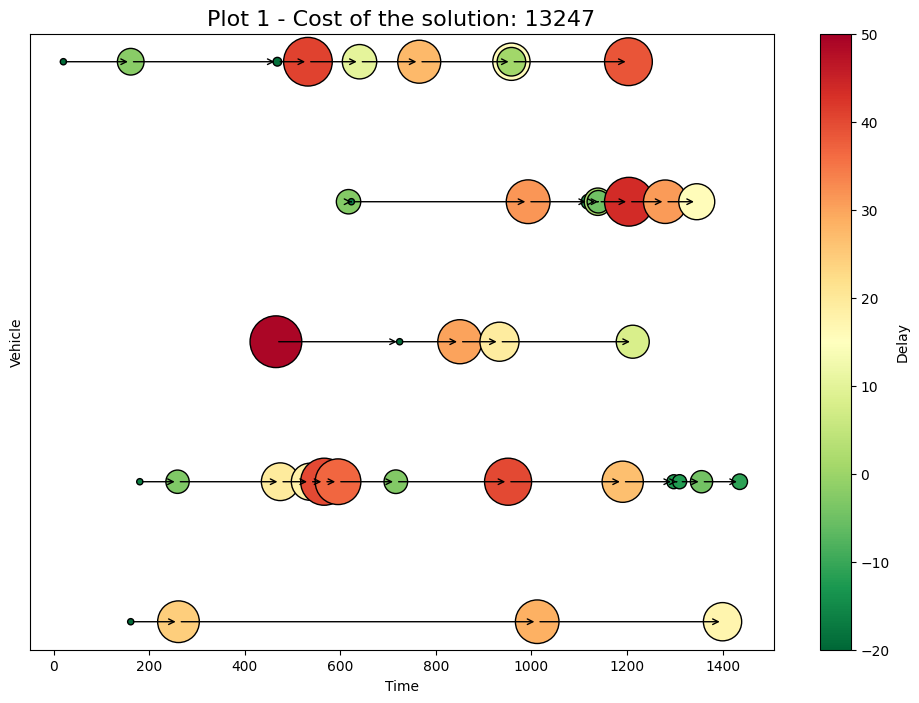

4
12


ValueError: s must be a scalar, or float array-like with the same size as x and y

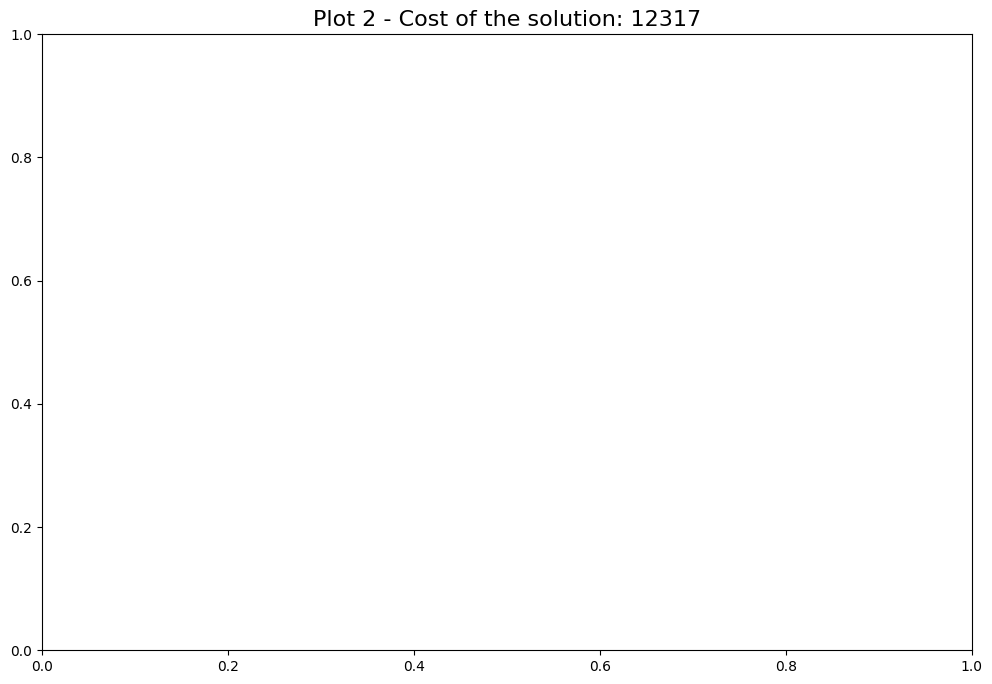

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

import random

# Function to generate data
def generate_data(N, M):
    times = np.random.randint(0, 1441, N)
    delays = np.random.uniform(-20, 50, N)
    paths = [[] for _ in range(M)]
    nodes = []

    for i in range(N):
        route_id = random.randint(0, M-1)
        node = {'name': i, 'time': times[i], 'delay': delays[i], 'route': route_id}
        nodes.append(node)
        paths[route_id].append(node)

    for i in range(M):
        paths[i] = sorted(paths[i], key=lambda x: x['time'])

    return paths, nodes


# Function to plot data
def create_path_prop_dict(paths):    
    path_props = [] 
    for i in range(len(paths)):
        path = paths[i]
        path_props.append(
            {
             "path": path,
             "props":{
                "times": [node['time'] for node in path] , 
                "delays": [node['delay'] for node in path], 
                "names": [node['name'] for node in path], 
             }
            }
        )
    return path_props


def plot_data(paths, title, fixed_positions=None, nodes=None):
    """
    If we use fixed positions, the node color, node radius and the edges are wrt @param paths, the positions are wrt fixed_positions
    """
    # Color map
    cmap = plt.get_cmap('RdYlGn_r')
    norm = mcolors.Normalize(vmin=-20, vmax=50)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title, fontsize=16)

    # create static positions
    path_props = create_path_prop_dict(paths)
    if fixed_positions is not None:
        fixed_path_props = create_path_prop_dict(fixed_positions)

    for i in range(len(paths)):
        path_prop = path_props[i]
        path = path_prop["path"]
        times = path_prop["props"]["times"]
        delays = path_prop["props"]["delays"]
        node_ids = path_prop["props"]["names"]


        if fixed_positions is not None:
            fixed_path_prop = fixed_path_props[i]
            fixed_path = fixed_path_prop["path"]
            fixed_times = fixed_path_prop["props"]["times"]
            fixed_delays = fixed_path_prop["props"]["delays"]

        # draw arrows
        for j in range(len(path) - 1):
            if fixed_positions is not None:
                ax.annotate('',
                            xy=(nodes[node_ids[j+1]]['time'], nodes[node_ids[j+1]]['route']),
                            xytext=(nodes[node_ids[j]]['time'], nodes[node_ids[j]]['route']),
                            arrowprops=dict(arrowstyle='->', color='k'))
            else:  
                ax.annotate('',
                    xy=(times[j + 1], path[j + 1]['route']),
                    xytext=(times[j], path[j]['route']),
                    arrowprops=dict(arrowstyle='->', color='k'))
                # ax.arrow()

        # draw nodes
        if fixed_positions is not None:
            ax.scatter(fixed_times, [node['route'] for node in fixed_path],
                                c=fixed_delays, s=(fixed_delays - min(fixed_delays)) * 20 + 20, # s is the scaling factor
                                cmap=cmap, norm=norm, edgecolor='black')
        else:
            ax.scatter(times, [node['route'] for node in path],
                                c=delays, s=(delays - min(delays)) * 20 + 20, 
                                cmap=cmap, norm=norm, edgecolor='black')

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Delay')
    cbar.set_ticks(np.linspace(-20, 50, 8))

    ax.set_xlabel('Time')
    ax.set_ylabel('Vehicle')
    ax.set_yticks([])  # Remove y-ticks
    plt.show()

# Parameters
N = 40  # Number of points
M = 5    # Number of vehicles

# Fixed nodes for the first plot
paths, nodes = generate_data(N, M)
plot_data(paths, f'Plot 1 - Cost of the solution: {np.random.randint(10000, 20000)}')

# Different datasets for the next two plots
for i in range(2):
    new_paths, _ = generate_data(N, M)
    plot_data(new_paths, f'Plot {i + 2} - Cost of the solution: {np.random.randint(10000, 20000)}', fixed_positions=paths, nodes=nodes)


### Inspecting the Dataset 
Check for city instances where the task is easy.

In [90]:
import pickle
from src.city import SimpleDirectedGraph, Vertex, Edge

def get_outgoing_edges(vertex: Vertex, graph: SimpleDirectedGraph, sol: list[int]) -> list[Edge]:
    result = []

    for i, e in enumerate(graph.get_edges()):
        if e.from_vertex == vertex and sol[i] == 1:
            result.append(e)

    return result

def check_easy_problems(data_path: str, config_path: str, with_city: bool):
    with open(config_path, "rb") as file:
        config = yaml.safe_load(file)
        print(f"config args: {config}")


    with open(data_path, "rb") as file:
        data = pickle.load(file)
        Y = data["Y"]
        graphs: SimpleDirectedGraph = list(map(lambda city: city.graph, data["cities"])) if with_city else data["graphs"]

    counter = 0

    for _, (g, s) in enumerate(zip(graphs, Y)):
        if len(get_outgoing_edges(g.get_source(), g, s)) == len(g.get_vertices())-2 or \
           len(get_outgoing_edges(g.get_source(), g, s)) == 1:
            counter += 1

    print(f"percentage easy problems: {counter/len(graphs)*100}")


def get_paths(data_path: str, config_path: str, with_city: bool):
    with open(config_path, "rb") as file:
        config = yaml.safe_load(file)
        print(f"config args: {config}")


    with open(data_path, "rb") as file:
        data = pickle.load(file)
        X = data["X"]
        Y = data["Y"]
        graphs: list[SimpleDirectedGraph] = list(map(lambda city: city.graph, data["cities"])) if with_city else data["graphs"]

    for i in range(len(data)):
        print(f"\n---------- City {i} ----------")
        
        # get graph props
        G = graphs[i]
        E = list(G.get_edges())
        edge_enum = list(enumerate(E))
        sol = Y[i]
        src_node = G.get_source()
        sink_node = G.get_sink()
        out_edges = get_outgoing_edges(src_node, G, sol)
        n_paths = len(out_edges)
        paths = {f"path_{n}": [out_edges[n]] for n in range(n_paths)}
        print("num vehicles: ", n_paths)

        # dfs to find paths
        for n in range(n_paths):
            e = out_edges[n]
            while not e.to_vertex == sink_node:
                next_out_edges = list(filter(lambda edge_enum: edge_enum[1].from_vertex == e.to_vertex, edge_enum))
                next_edges = list(filter(lambda edge_enum: sol[edge_enum[0]] == 1, next_out_edges))
                assert len(next_edges) == 1 # the path should be distinct
                e = next_edges[0][1]
                paths[f"path_{n}"].append(e)
                
            print(f"path of vehicle {n}: ", [ee.name for ee in paths[f"path_{n}"]])

In [68]:
# tune hyperparameters to check factor of easy instances
check_easy_problems(data_path="data/paper_config.pkl",
                    config_path="configs/paper_config.yaml",
                    with_city=True)

config args: {'data': {'path': 'data/test.pkl', 'city': True, 'split': {'train': 0.34, 'val': 0.33, 'test': 0.33}}, 'train': {'criterion': {'name': 'FenchelYoungLoss', 'args': {'batched': False, 'maximize': False, 'sigma': 0.1, 'num_samples': 100}}, 'batch_size': 1, 'metrics': {'train_and_validation': None, 'train': None, 'validation': None}, 'optimizer': {'name': 'AdamW', 'args': None}, 'n_epochs': 200, 'save_every_n_epochs': 50, 'save_dir': 'models/10tasks5scenarios', 'eval_every_n_epochs': 1}, 'model': {'name': 'FenchelYoungGLM', 'args': {'n_features': 20}}}
percentage easy problems: 0.0


Show the solution paths of the dataset. Each color indicates one vehicle.


In [89]:
get_paths(data_path="data/paper_config.pkl",
          config_path="configs/paper_config.yaml",
          with_city=True)
        

config args: {'data': {'path': 'data/test.pkl', 'city': True, 'split': {'train': 0.34, 'val': 0.33, 'test': 0.33}}, 'train': {'criterion': {'name': 'FenchelYoungLoss', 'args': {'batched': False, 'maximize': False, 'sigma': 0.1, 'num_samples': 100}}, 'batch_size': 1, 'metrics': {'train_and_validation': None, 'train': None, 'validation': None}, 'optimizer': {'name': 'AdamW', 'args': None}, 'n_epochs': 200, 'save_every_n_epochs': 50, 'save_dir': 'models/10tasks5scenarios', 'eval_every_n_epochs': 1}, 'model': {'name': 'FenchelYoungGLM', 'args': {'n_features': 20}}}

---------- City 0 ----------
num vehicles:  9
edge 25->0: 
path of vehicle 0:  ['25->0', '0->9', '9->26']
edge 25->1: 
path of vehicle 1:  ['25->1', '1->2', '2->3', '3->26']
edge 25->4: 
path of vehicle 2:  ['25->4', '4->5', '5->14', '14->16', '16->26']
edge 25->6: 
path of vehicle 3:  ['25->6', '6->19', '19->26']
edge 25->7: 
path of vehicle 4:  ['25->7', '7->11', '11->26']
edge 25->8: 
path of vehicle 5:  ['25->8', '8->10', '